In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
from IPython import display
# %matplotlib
from mpl_toolkits import mplot3d 
import math
tf.random.set_seed(6)
np.random.seed(6)

TensorFlow version: 2.1.0
Eager execution: True


# Scheme2

In [2]:
def plot_helper2(LOSS, LOSS_AVERAGE):
    
    fig2 = plt.figure(figsize=(12,4))
    ax1 = plt.subplot(131)
    ax1.plot(np.arange(len(LOSS[0:])),LOSS[0:],lw = 1)
    ax1.plot([0,len(LOSS[0:])],[rho_optimal,rho_optimal],lw = 1)
    ax1.grid()
    
    ax2 = plt.subplot(132)
    ax2.plot(np.arange(len(LOSS_AVERAGE[0:])),LOSS_AVERAGE[0:],lw = 1)
    ax2.plot([0,len(LOSS_AVERAGE[0:])],[rho_optimal,rho_optimal],lw = 1)
    ax2.grid()
    
    ax3 = plt.subplot(133)
    ax3.plot(np.arange(len(LOSS[-100:])),LOSS[-100:],lw = 1)
    ax3.plot([0,len(LOSS[-100:])],[rho_optimal,rho_optimal],lw = 1)
    ax3.grid()

    plt.show(fig2)

    del fig2

In [3]:
dt = 0.01
N = 100
M = 100
T = dt*N

# Case Brownian Motion
d = 1
gamma = np.array([0])
w = np.array([1])

# Case OU process
# d = 1
# gamma = np.array([1])
# w = np.array([1])

# Case Multi-OU process
# d = 10
# gamma = np.arange(d)
# w = np.ones(d)/d

# d = 50
# gamma = np.arange(d)/10
# w = np.ones(d)/d

# d = 100
# gamma = np.arange(d)/10
# w = np.ones(d)/d

# Case fBM
# gamma = gamma_grid
# w = c_grid
# d = gamma.shape[0]


b = -w/(1+gamma)
c = np.zeros(shape = (d,d))
rho_optimal = 0
for i in range(d):
    for j in range(d):
        if i == j:
            c[i,j] = w[i]*w[j]*(gamma[i]+2)/2/(gamma[i]+1)**2
        else:
            c[i,j] = w[i]*w[j]*(gamma[i]+gamma[j]+gamma[i]*gamma[j])\
            /((gamma[i]+1)*(gamma[j]+1)*(gamma[i]+gamma[j]))
        rho_optimal += c[i,j]
b = tf.constant(b,shape = [d,1])
c = tf.constant(c,shape = [d,d])

mean = np.zeros(d+1)
cov = np.zeros((d+1,d+1))

cov_xx = np.zeros((d,d))
for i in range(d):
    for j in range(d):
        cov_xx[i,j] = (gamma[i]*gamma[j]+gamma[i]+gamma[j]+1)/\
        (2*(gamma[i]+gamma[j])*(gamma[i]+1)**2*(gamma[j]+1)**2)
        
for i in range(d):
    for j in range(d):
        tmp = gamma[i] + gamma[j]
        if tmp != 0:
            cov[i+1,j+1] = 1/tmp
        else:
            cov[i+1,j+1] = 1/tmp
                
cov[0,0] = np.matmul(np.reshape(w,[1,-1]),np.matmul(cov_xx,np.reshape(w,[-1,1])))[0,0]        
for i in range(d):
    tmp = 0
    for j in range(d):
        tmp += w[i]/((gamma[i]+gamma[j])*(gamma[i]+1)*(gamma[j]+1))
    cov[i+1,0] = tmp
    cov[0,i+1] = tmp
    
mean0 = np.zeros(d+1)
cov0 = np.zeros((d+1,d+1))
cov1 = np.eye(d+1)
def V_optimal(x):
    u = x[:,:1]
    y = x[:,1:]
    opt1 = tf.square(u)
    opt2 = 2*tf.linalg.matmul(tf.multiply(u,y),b)
    opt3 = tf.reduce_sum(y*tf.linalg.matmul(y,c),axis = -1, keepdims = True)
    return opt1 + opt2 + opt3
def dVdu_optimal(x):
    u = x[:,:1]
    y = x[:,1:]
    opt = 2*u + 2*tf.linalg.matmul(y,b)
    return opt
def dVdy_optimal(x):
    u = x[:,:1]
    y = x[:,1:]
    opt1 = 2*tf.linalg.matmul(u,tf.reduce_sum(b, keepdims = True))
    opt2 = 2 * tf.reduce_sum(tf.linalg.matmul(y,c),axis = -1, keepdims = True)
    return opt1 + opt2
def u_optimal(x):
    u = x[:,:1]
    y = x[:,1:]
    opt = -u - tf.linalg.matmul(y,b)
    return opt
rho_optimal

C:\SongyanHou\Programs\Anaconda3\envs\justin\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in long_scalars
C:\SongyanHou\Programs\Anaconda3\envs\justin\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in long_scalars
C:\SongyanHou\Programs\Anaconda3\envs\justin\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in long_scalars


1.0

In [4]:
fbm_optimal = (1 + 1/np.sin(np.pi*H))/2
fbm_optimal

NameError: name 'H' is not defined

In [5]:
# General neural network
inputs = keras.Input(shape=(d+1,),dtype = 'float64')
inputs0 = tf.zeros_like(inputs)
inputs_inverse = - inputs
layer1 = layers.Dense(8, activation = 'elu', dtype = 'float64')
layer2 = layers.Dense(8, activation = 'elu', dtype = 'float64')
layer3 = layers.Dense(1, activation = 'elu', dtype = 'float64')
layer4 = layers.Dense(1, activation = 'elu', use_bias = False, dtype = 'float64')
outputs = layer3(layer2(tf.square(layer1(inputs)))) + layer3(layer2(tf.square(layer1(inputs_inverse))))
outputs0 = 2*layer3(layer2(tf.square(layer1(inputs0))))
outputs = outputs - outputs0 
model = keras.Model(inputs=inputs, outputs=outputs)
rho = tf.Variable([[2.]],dtype = 'float64')


In [6]:
def get_data_stationary(seed,dt,N,M,mean,cov):
#     np.random.seed(seed)
    y = np.random.multivariate_normal(mean[1:], cov[1:,1:], M)
    u = np.zeros(shape = (M,1))
    U_train = tf.Variable(u)
    Y_train = tf.Variable(y)
    dW_train = [tf.Variable(np.random.normal(0,np.sqrt(dt),size = (M,1))) for i in range(N)]
    return U_train, Y_train, dW_train

In [7]:
def get_data(seed,dt,N,M,mean,cov):
#     np.random.seed(seed)
    x = np.random.multivariate_normal(mean, cov, M)
    u = x[:,:1]
    y = x[:,1:]
    U_train = tf.Variable(u)
    Y_train = tf.Variable(y)
    dW_train = [tf.Variable(np.random.normal(0,np.sqrt(dt),size = (M,1))) for i in range(N)]
    return U_train, Y_train, dW_train

In [8]:
# Theoretical optimal loss
def optimal_loss(U0, Y0, dW):
    U = [0]*(N+1)
    Y = [0]*(N+1)
    X = [0]*(N+1)
    V = [0]*(N+1)
    dVdU = [0]*N
    dVdY = [0]*N
    control = [0]*N
    U[0] = U0
    Y[0] = Y0
    bsde = 0
    loss = 0
    for steps in range(N):
        X[steps] = tf.concat([U[steps],Y[steps]],axis = -1)
        V[steps] = V_optimal(X[steps])
        dVdU[steps] = dVdu_optimal(X[steps])
        dVdY[steps] = dVdy_optimal(X[steps])
        control[steps] = - 0.5*dVdU[steps]
        U[steps+1] = U[steps] + control[steps] * dt
        Y[steps+1] = Y[steps] + dW[steps] - gamma*Y[steps]*dt ##############################################################
        loss = loss + (tf.square(U[steps] - tf.reduce_sum(Y[steps]*w,axis = -1,keepdims = True))\
                       + tf.square(control[steps]))*dt
        bsde = bsde + tf.multiply(dVdY[steps],dW[steps])
    X[N] = tf.concat([U[N],Y[N]],axis = -1)
    V[N] = V_optimal(X[N])    
    outputs = loss + V[N] - V[0] - bsde
    Eloss = tf.reduce_mean(tf.square(outputs))
    return Eloss.numpy(), loss, U[-1], Y[-1]
# U0, Y0, dW = get_data(0,dt,N,M,mean,cov,d)
# optimal_loss(U0, Y0, dW)

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
@tf.function
def train_step(U0, Y0, dW):
    grad = 0
    U = [0]*(N+1)
    Y = [0]*(N+1)
    X = [0]*(N+1)
    V = [0]*(N+1)
    dVdU = [0]*N
    dVdY = [0]*N
    control = [0]*N
    with tf.GradientTape(persistent=True) as tape0:
        U[0] = U0
        Y[0] = Y0
        bsde = 0
        loss = 0
        for steps in range(N):
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(U[steps])
                tape.watch(Y[steps])
                X[steps] = tf.concat([U[steps],Y[steps]],axis = -1)
                V[steps] = model(X[steps])
    #             V0 = tf.square(U0 - Y0)
            dVdU[steps] = tape.gradient(V[steps], U[steps])
            dVdY[steps] = tape.gradient(V[steps], Y[steps])
            control[steps] = - 0.5*dVdU[steps]
            U[steps+1] = U[steps] + control[steps] * dt
            Y[steps+1] = Y[steps] + dW[steps] - gamma*Y[steps]*dt 
            loss = loss + (tf.square(U[steps] - tf.reduce_sum(Y[steps]*w,axis = -1,keepdims = True))\
                           + tf.square(control[steps]))*dt
            bsde = bsde + tf.multiply(tf.reduce_sum(dVdY[steps],axis = -1,keepdims = True),dW[steps])
        X[N] = tf.concat([U[N],Y[N]],axis = -1)
        V[N] = model(X[N])    
        outputs = loss + V[N] - V[0] - bsde
        Eloss = tf.reduce_mean(tf.square(outputs))
#     grad = tape0.gradient(Eloss, model.trainable_variables + [rho]) 
    grad_V = tape0.gradient(Eloss, model.trainable_variables) 
#     grad_rho = tape0.gradient(Eloss, [rho])  
#     optimizer.apply_gradients(zip(grad, model.trainable_weights + [rho]))
#     optimizer_V.apply_gradients(zip(grad_V, model.trainable_weights))
#     optimizer_rho.apply_gradients(zip(grad_rho, [rho])) 
    return Eloss, loss, grad_V, U[-1], Y[-1]

### Under optimal control

dt: 0.01 N: 100 M: 100 T: 1.0
Cov_start: [[0. 0.]
 [0. 0.]]
Total epochs: 1000
Epoch:  0
Loss:  1.0012419276674285


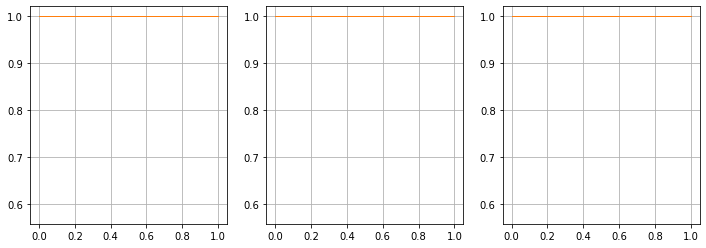

Avarage running loss of latest 100 epochs:  0.5783435825403218
Epoch:  50
Loss:  1.043784541847538


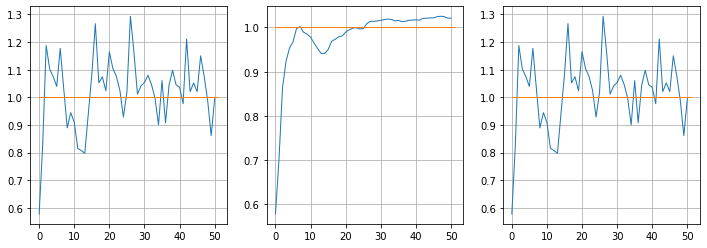

Avarage running loss of latest 100 epochs:  1.0209309889471927
Epoch:  100
Loss:  1.0037394242690272


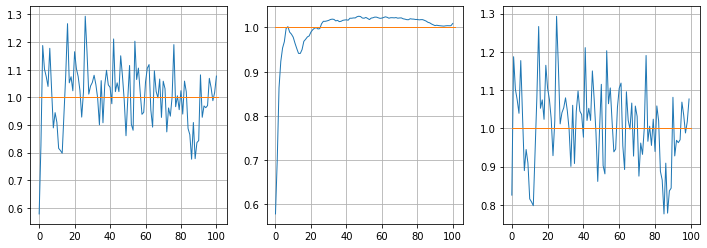

Avarage running loss of latest 100 epochs:  1.0090682072772996
Epoch:  150
Loss:  1.0580571985562912


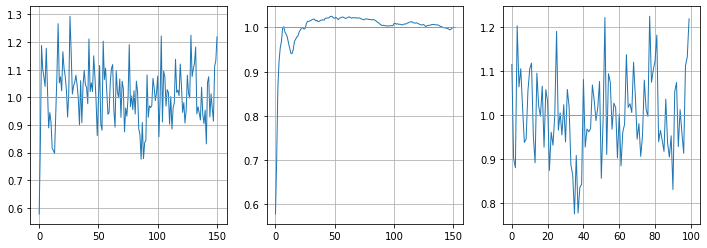

Avarage running loss of latest 100 epochs:  1.0008947311249674
Epoch:  200
Loss:  1.0528583869291808


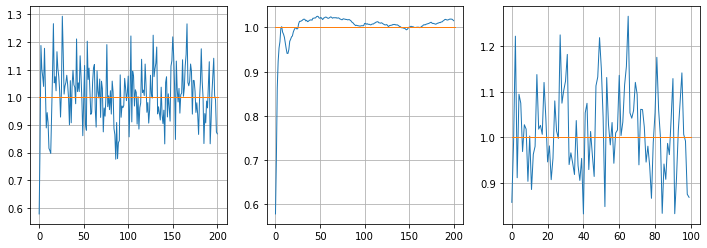

Avarage running loss of latest 100 epochs:  1.0153973503272704
Epoch:  250
Loss:  1.0097327124730737


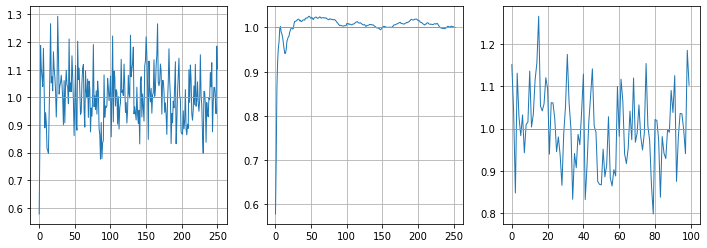

Avarage running loss of latest 100 epochs:  1.000858166283046
Epoch:  300
Loss:  1.0131252839153893


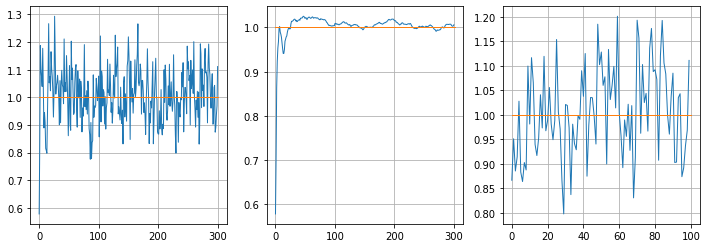

Avarage running loss of latest 100 epochs:  1.0061666641958598
Epoch:  350
Loss:  1.0341544884444582


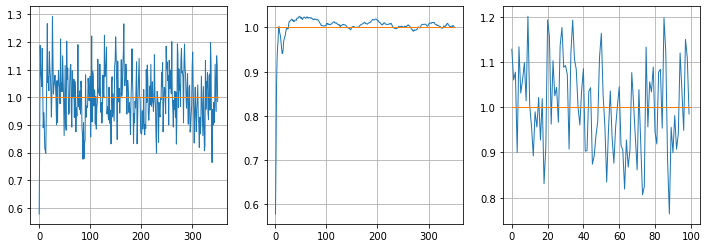

Avarage running loss of latest 100 epochs:  1.002469852520866


KeyboardInterrupt: 

In [20]:
LOSS_opt = []
LOSS_AVERAGE_opt  = []
RHO_opt = []
covMatrix = cov0 + 0.

epochs = 1000

print('dt:',dt,'N:', N, 'M:', M, 'T:', T)
print('Cov_start:',cov0)
print('Total epochs:',epochs)

for epoch in range(epochs):   
    if epoch == 0:
        U0, Y0, dW = get_data(epoch,dt,N,M,mean0,cov0)  
    else:
        U0 = U_end
        Y0 = Y_end
        _, _, dW = get_data(epoch,dt,N,M,mean0,cov0)    

    Eloss, loss, U_end, Y_end = optimal_loss(U0, Y0, dW)
    LOSS_opt.append(loss.numpy().mean()/T)
    LOSS_AVERAGE_opt.append(np.array(LOSS_opt[-100:]).mean())

    if epoch%50 == 0 or epoch == epochs-1:
        print('='*90)
        print('Epoch: ',epoch)
        print('Loss: ', Eloss)
        plot_helper2(LOSS_opt, LOSS_AVERAGE_opt)
        print('Avarage running loss of latest 100 epochs: ',LOSS_AVERAGE_opt[-1])


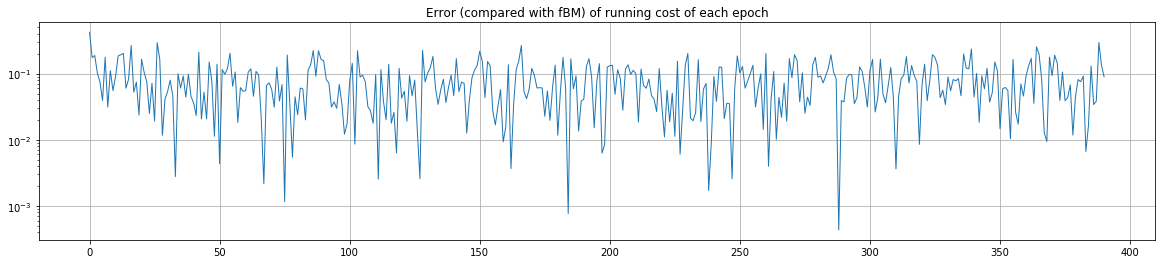

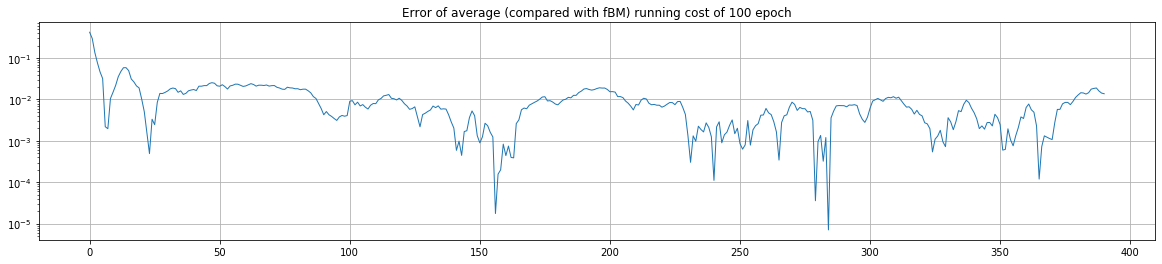

In [23]:
fig1 = plt.figure(figsize = (20,4)) 
plt.semilogy(np.abs(np.array(LOSS_opt)-rho_optimal),'-',lw = 1)
plt.grid()
plt.title('Error (compared with fBM) of running cost of each epoch')
plt.show()


fig2 = plt.figure(figsize = (20,4)) 
plt.semilogy(np.abs(np.array(LOSS_AVERAGE_opt)-rho_optimal),'-',lw = 1)
plt.grid()
plt.title('Error of average (compared with fBM) running cost of 100 epoch')
plt.show()


## Under Neural Network

In [11]:
LOSS = []
LOSS_AVERAGE = []
RHO = []
covMatrix = cov0 + 0.

In [12]:
epochs = 5000

print('dt:',dt,'N:', N, 'M:', M, 'T:', T)
print('Cov_start:',cov0)
print('Total epochs:',epochs)

for epoch in range(epochs):   
    if epoch == 0:
        U0, Y0, dW = get_data(epoch,dt,N,M,mean0,covMatrix)  
        pass
    elif epoch%50 == 0:
        U0 = U_end
        Y0 = Y_end
        _, _, dW = get_data(epoch,dt,N,M,mean0,covMatrix)
    else:
        _, _, dW = get_data(epoch,dt,N,M,mean0,covMatrix)
#     _, Y0, _ = get_data_stationary(1,dt,N,M,mean0,cov)
#     U0, Y0, dW = get_data_stationary(epoch,dt,N,M,mean0,cov)      

    Eloss, loss, gg, U_end, Y_end = train_step(U0, Y0, dW)
    optimizer.apply_gradients(zip(gg, model.trainable_weights))
    
    opt_loss,_,_,_ = optimal_loss(U0, Y0, dW)
    LOSS.append(loss.numpy().mean()/T)
    LOSS_AVERAGE.append(np.array(LOSS[-100:]).mean())
    RHO.append(rho.numpy()[0,0])

    if epoch%50 == 0 or epoch == epochs-1:
        print('='*90)
        print('Epoch: ',epoch)
        print('Loss: ', Eloss.numpy())
        print('Loss under optimal control: ', opt_loss)
        plot_helper2(LOSS, LOSS_AVERAGE)
        print('Avarage running loss of latest 100 epochs: ',LOSS_AVERAGE[-1])
        print('rho:',rho.numpy()[0,0])
#         UU , YY, _ = get_data_stationary(1,dt,N,M,mean0,cov)
#         X = tf.concat([UU,YY],axis = -1)
#         l2loss = tf.norm(V_optimal(X) - model(X),ord=2)/10
#         print(l2loss.numpy())


dt: 0.01 N: 100 M: 100 T: 1.0
Cov_start: [[0. 0.]
 [0. 0.]]
Total epochs: 5000


KeyboardInterrupt: 

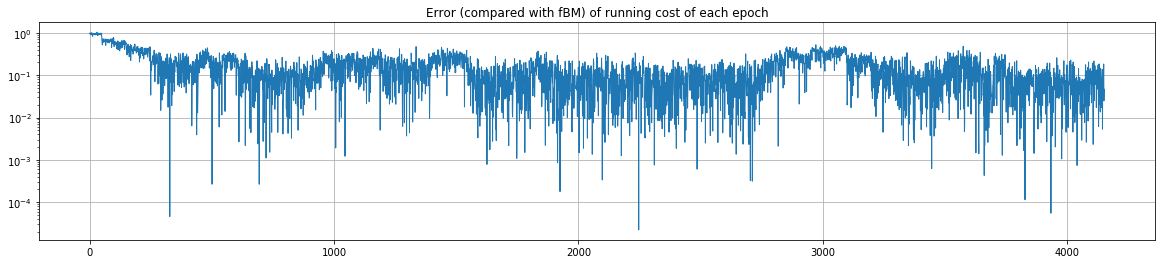

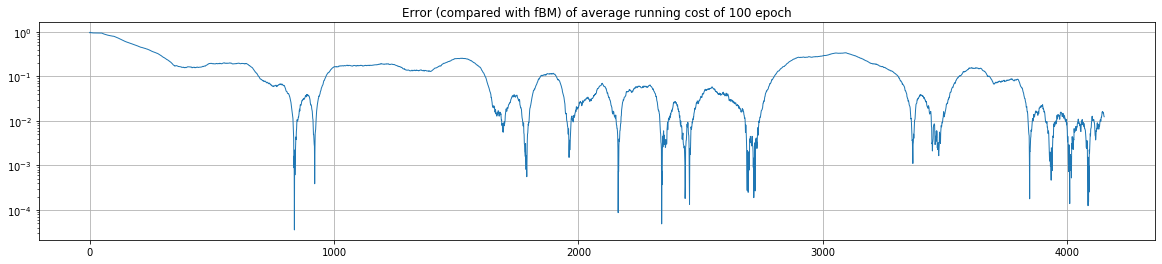

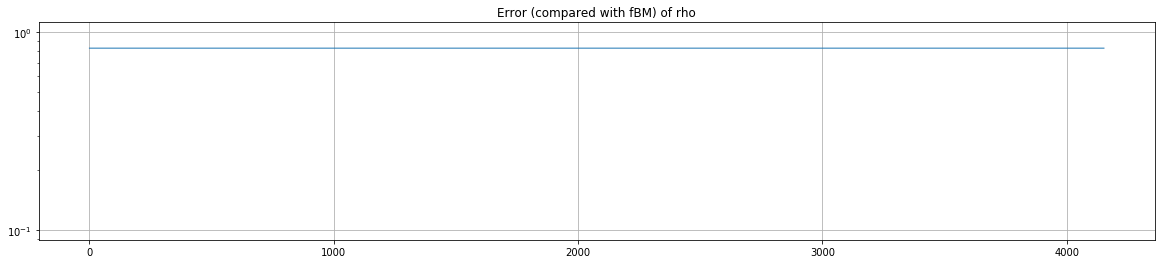

In [52]:
fig1 = plt.figure(figsize = (20,4)) 
plt.semilogy(np.abs(np.array(LOSS)-fbm_optimal),'-',lw = 1)
plt.grid()
plt.title('Error (compared with fBM) of running cost of each epoch')
plt.show()


fig2 = plt.figure(figsize = (20,4)) 
plt.semilogy(np.abs(np.array(LOSS_AVERAGE)-fbm_optimal),'-',lw = 1)
plt.grid()
plt.title('Error (compared with fBM) of average running cost of 100 epoch')
plt.show()

fig3 = plt.figure(figsize = (20,4)) 
plt.semilogy(np.abs(np.array(RHO)-fbm_optimal),'-',lw = 1)
plt.grid()
plt.title('Error (compared with fBM) of rho')
plt.show()